<h1 style = "font-size:3rem;color:blue;"> Drifter Data Analysis</h1>



Data formatting for Biogeochemical Drifter field observations


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Read in data and parse by column header


In [29]:
filename = '80010502'

YSIfilename = 'Mar24YSIData'

fullname = filename+'.csv'

YSIfullname = YSIfilename+ '.csv'

filepath = os.path.join('D:', fullname) # PJB: changed from "'D', fullname" to "'Data', fullname"

YSIfilepath = os.path.join('D:', YSIfullname) # PJB: ditto


df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None)

YSIdf = pd.read_csv(YSIfilepath, parse_dates = [[0, 1]], header = None, encoding = 'utf-16', skiprows = 17)
df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'altitude', 'speed', 'angle', 'pH', 'Temperature (C)', 'DO (mg/L)', 'Conductivity (uS/cm)']

YSIdf.columns = ['Time',	'Time (Fract. Sec)',	'Site Name',	'Chlorophyll RFU',	'Cond µS/cm',	'Depth m',	'fDOM QSU',	'fDOM RFU',	'nLF Cond µS/cm',	'ODO % sat',	'ODO % local',	'ODO mg/L',	'Pressure psi a',	'Sal psu',	'SpCond µS/cm',	'TAL PE RFU',	'TDS mg/L',	'Turbidity FNU',	'TSS mg/L',	'pH',	'pH mV',	'Temp °C',	'Vertical Position m',	'GPS Latitude °',	'GPS Longitude °',	'Altitude m',	'Battery V',	'Cable Pwr V',	'Barometer mmHg']
 

df = df.truncate(before = 12925, after = 53000, copy = None)

df.head()

YSIdf.head()



,Time,Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,fDOM QSU,fDOM RFU,nLF Cond µS/cm,ODO % sat,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2025-03-24 16:14:02,0.0,<None>,0.09,44166.1,0.125,17.24,5.75,50301.9,95.6,...,5.9,33.7,19.085,0.130,0.0,0.0,0.0,0.0,12.0,757.9
1,2025-03-24 16:14:03,0.0,<None>,0.09,44166.0,0.125,17.27,5.76,50301.7,95.6,...,5.9,33.7,19.085,0.121,0.0,0.0,0.0,0.0,12.0,757.9
2,2025-03-24 16:14:04,0.0,<None>,0.09,44166.0,0.125,17.26,5.75,50301.7,95.6,...,5.9,33.7,19.085,0.128,0.0,0.0,0.0,0.0,12.0,757.9
3,2025-03-24 16:14:05,0.0,<None>,0.09,44165.9,0.125,17.23,5.74,50301.5,95.6,...,5.9,33.7,19.085,0.127,0.0,0.0,0.0,0.0,12.0,757.9
4,2025-03-24 16:14:06,0.0,<None>,0.08,44165.9,0.125,17.26,5.75,50301.6,95.6,...,5.9,33.7,19.085,0.125,0.0,0.0,0.0,0.0,12.0,757.9


In [115]:
def lat_convert(lat_badfmt):
    """Convert latitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lat_badfmt = str(lat_badfmt)
        lat_DD = int(float(lat_badfmt) / 100)  # Extract degrees
        lat_MM = float(lat_badfmt) - lat_DD * 100  # Extract minutes
        return lat_DD + lat_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

def lon_convert(lon_badfmt):
    """Convert longitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lon_badfmt = str(lon_badfmt)
        lon_DD = int(float(lon_badfmt) / 100)  # Extract degrees
        lon_MM = float(lon_badfmt) - lon_DD * 100  # Extract minutes
        return lon_DD + lon_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

# Apply conversions
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# Fix South (negative latitudes)
df.loc[df['N or S'] == 'S', 'lat'] *= -1

# Fix West (negative longitudes)
df.loc[df['E or W'] == 'W', 'lon'] *= -1

# Check output
df.head()


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm),lat,lon
1111,2025-02-12 19:27:28,2225,3408.46704,N,7752.03516,W,11.6,0.27,251.49,8.5,13.59,3.04,46710.0,34.141117,-77.867253
1112,2025-02-12 19:27:30,2227,3408.46704,N,7752.03467,W,11.6,0.12,251.49,8.5,13.59,3.05,46690.0,34.141117,-77.867244
1113,2025-02-12 19:27:32,2229,3408.46680,N,7752.03467,W,11.6,0.06,251.49,8.5,13.59,3.08,46690.0,34.141113,-77.867244
1114,2025-02-12 19:27:34,2231,3408.46680,N,7752.03467,W,11.6,0.58,109.98,8.5,13.59,3.09,46710.0,34.141113,-77.867244
1115,2025-02-12 19:27:36,2233,3408.46680,N,7752.03418,W,11.6,0.56,109.98,8.5,13.59,3.09,46670.0,34.141113,-77.867236


In [117]:
def plot_gps_points(lon, lat):
     fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}) 
     stamen_terrain = cimgt.Stamen('terrain')
     ax.add_image(stamen_terrain, 8)
    
    # Plot the GPS points
     ax.plot(lon, lat, 'bo', markersize=5, transform=ccrs.PlateCarree())
    
    # Add gridlines
     gl = ax.gridlines(draw_labels=True)
     gl.xlabels_top = False
     gl.ylabels_right = False
     gl.xformatter = LONGITUDE_FORMATTER
     gl.yformatter = LATITUDE_FORMATTER
    
     plt.show(df.lon,df.lat)


In [119]:
## Mapbox
map_id = 'streets-v11'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 20
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'depth (cm)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)
# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally




NameError: name 'mapbox_access_token' is not defined

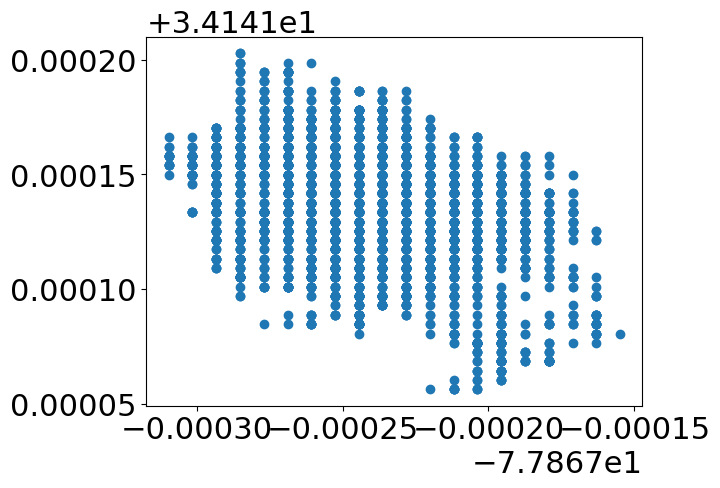

In [121]:
plt.scatter(df.lon, df.lat)


### Begin analyzing time-series data
Comparison between the Drifter time series of pH and the YSI EXO2s sonde.

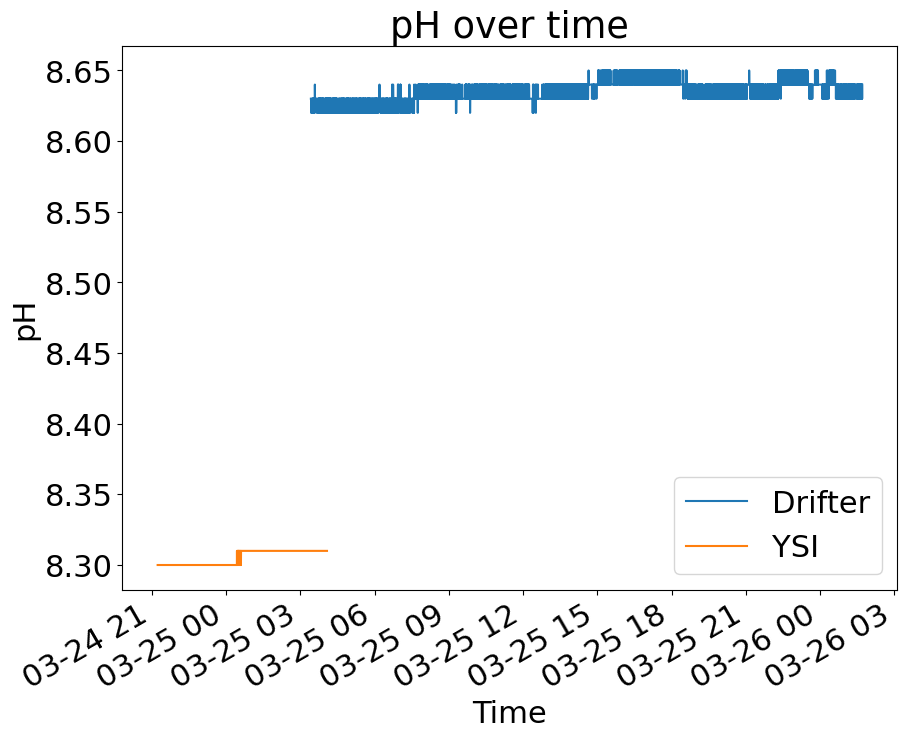

In [31]:
time = df['time']
ph = df['pH']
YSItime = YSIdf['Time']
YSIph = YSIdf['pH'] + 2.4 # Adding 2.4 to bring the YSI pH reading closer to drifters since YSI pH probe was not calibrated
hours_to_add = 5 # Adding 5 hours to convert from EST to UTC to put the YSI in "correct" time zone
YSItime = YSItime + pd.Timedelta(hours= hours_to_add)

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access

plt.plot(time,ph, label = "Drifter")
plt.plot(YSItime,YSIph, label = "YSI")
plt.title('pH over time')
plt.xlabel('Time')
plt.ylabel('pH')
axs.legend()
fig.autofmt_xdate()

# PJB: Stephen, add legend to graph


### Analyze and visualize dissolved oxygen
Plot the DO measured by the drifter to that of the YSI EXO2s to determine the quality of the drifters readings

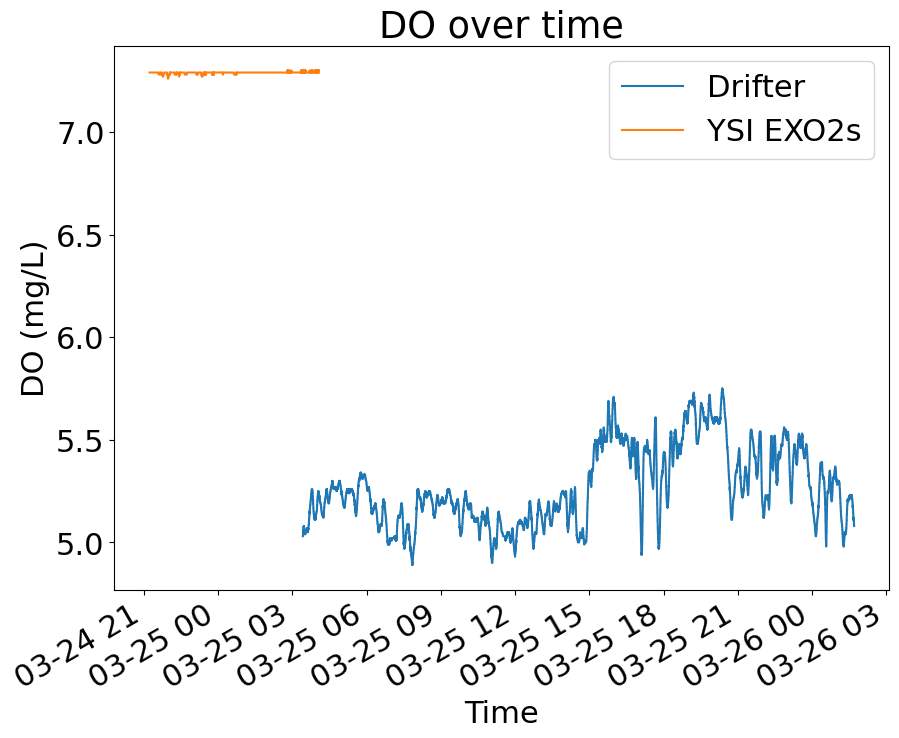

In [33]:
DO = df['DO (mg/L)'] +4 #Use +4 as a one point calibration correction for the Drifter
YSIDO = YSIdf['ODO mg/L'] 

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,DO, label = 'Drifter')
plt.plot(YSItime, YSIDO, label = 'YSI EXO2s')
plt.title('DO over time')
plt.xlabel('Time')
plt.ylabel('DO (mg/L)')
axs.legend()
fig.autofmt_xdate()

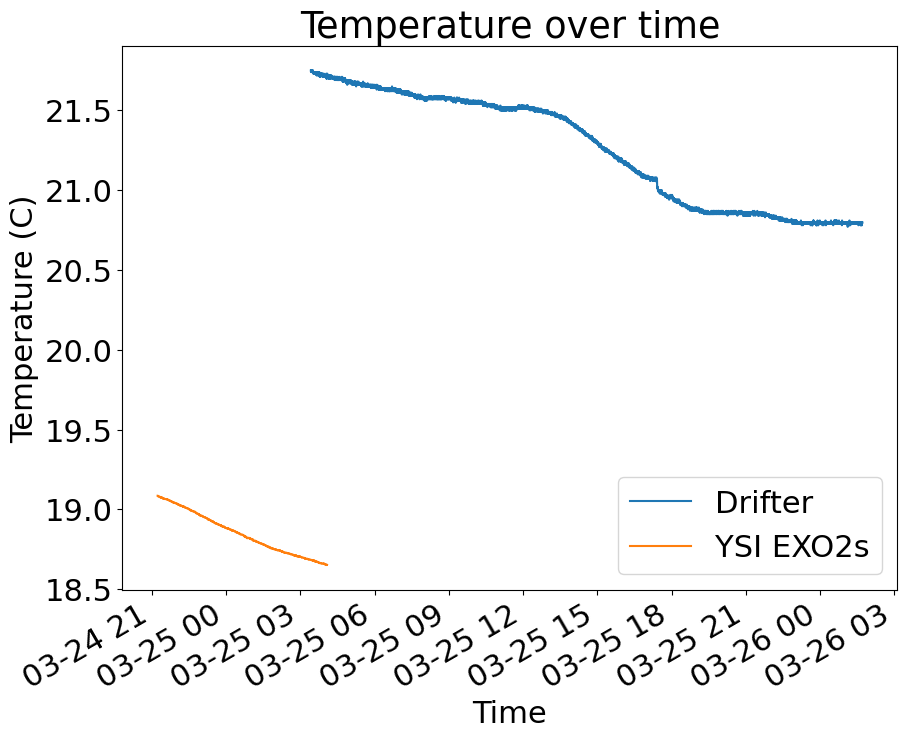

In [35]:
temp = df['Temperature (C)'] - 0.6 #correct the temperature probe as much as possible 
YSItemp = YSIdf['Temp °C']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,temp, label = 'Drifter')
plt.plot(YSItime,YSItemp, label = 'YSI EXO2s')
plt.title('Temperature over time')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
axs.legend()
fig.autofmt_xdate()

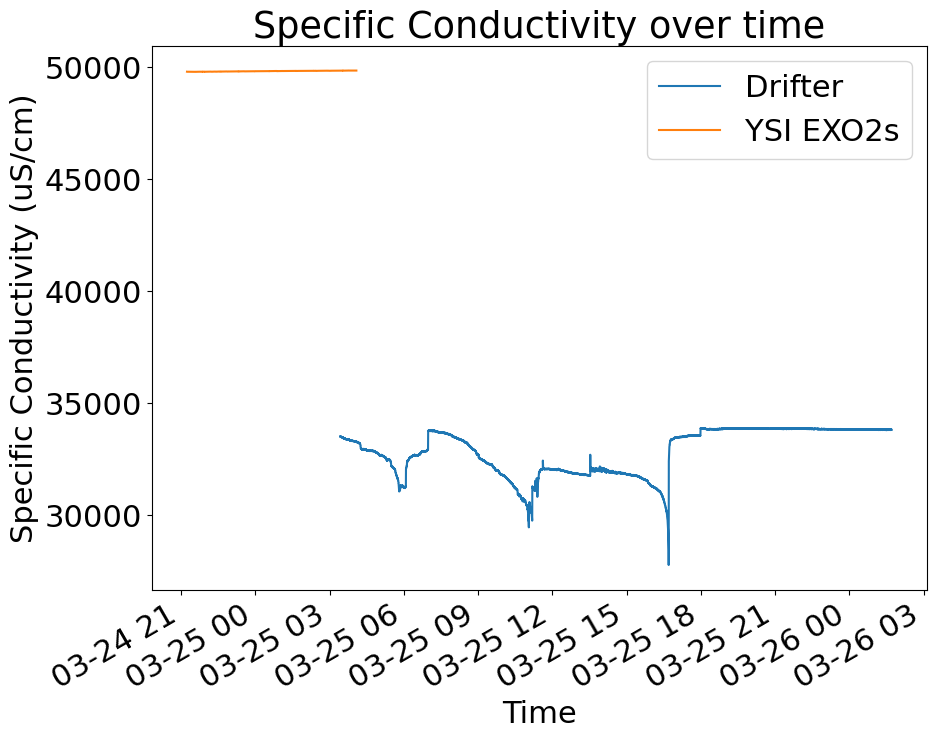

In [37]:
spcond = df['Conductivity (uS/cm)'] +4000 #point calibration for drifter
YSIspcond = YSIdf['SpCond µS/cm']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,spcond, label = 'Drifter')
plt.plot(YSItime,YSIspcond, label = 'YSI EXO2s')
plt.title('Specific Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Specific Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()

In [23]:
#interpolation section

Drifter_on_YSI_time = np.interp(YSItime, # new timestamp
                                        df.loc[:, 'time'],         # old timestamp
                                        df.loc[:, 'DO (mg/L)'],   # old data
                                        left = np.nan, right = np.nan)

Drifter_minus_YSI_anomaly = Drifter_on_YSI_time-YSIdf.loc[:, 'ODO mg/L']

Drifter_on_YSI_time

array([nan, nan, nan, ..., nan, nan, nan])

### NOTE: 
Cutting rmse calculation, print statement, and plotting out of cell above and into new cell below. Given hard to understand results (i.e., "nan"), print out variables to examine in more detail before proceeding with analysis.

First variable I printed as output to cell above (`Drifter_on_YSI_time`) suggests that it *might* be filled with NaNs. We'd want to dig deeper to confirm whether it was *all* NaNs or just some, but without going further down that route, I can immediately see an issue with the timestamps that you are using here. You created a new time variable for the YSI above to align it with the Drifter's time(zone) but then didn't use it here! Use the matching/aligned times here next and see what happens.

nan nan 0.0


C:\Users\Stephen\AppData\Local\Temp\ipykernel_25424\2154640298.py:3: RuntimeWarning: Mean of empty slice
  print(np.nanmean(Drifter_minus_YSI_anomaly), np.nanstd(Drifter_minus_YSI_anomaly), rmse_drifter)
C:\Users\Stephen\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


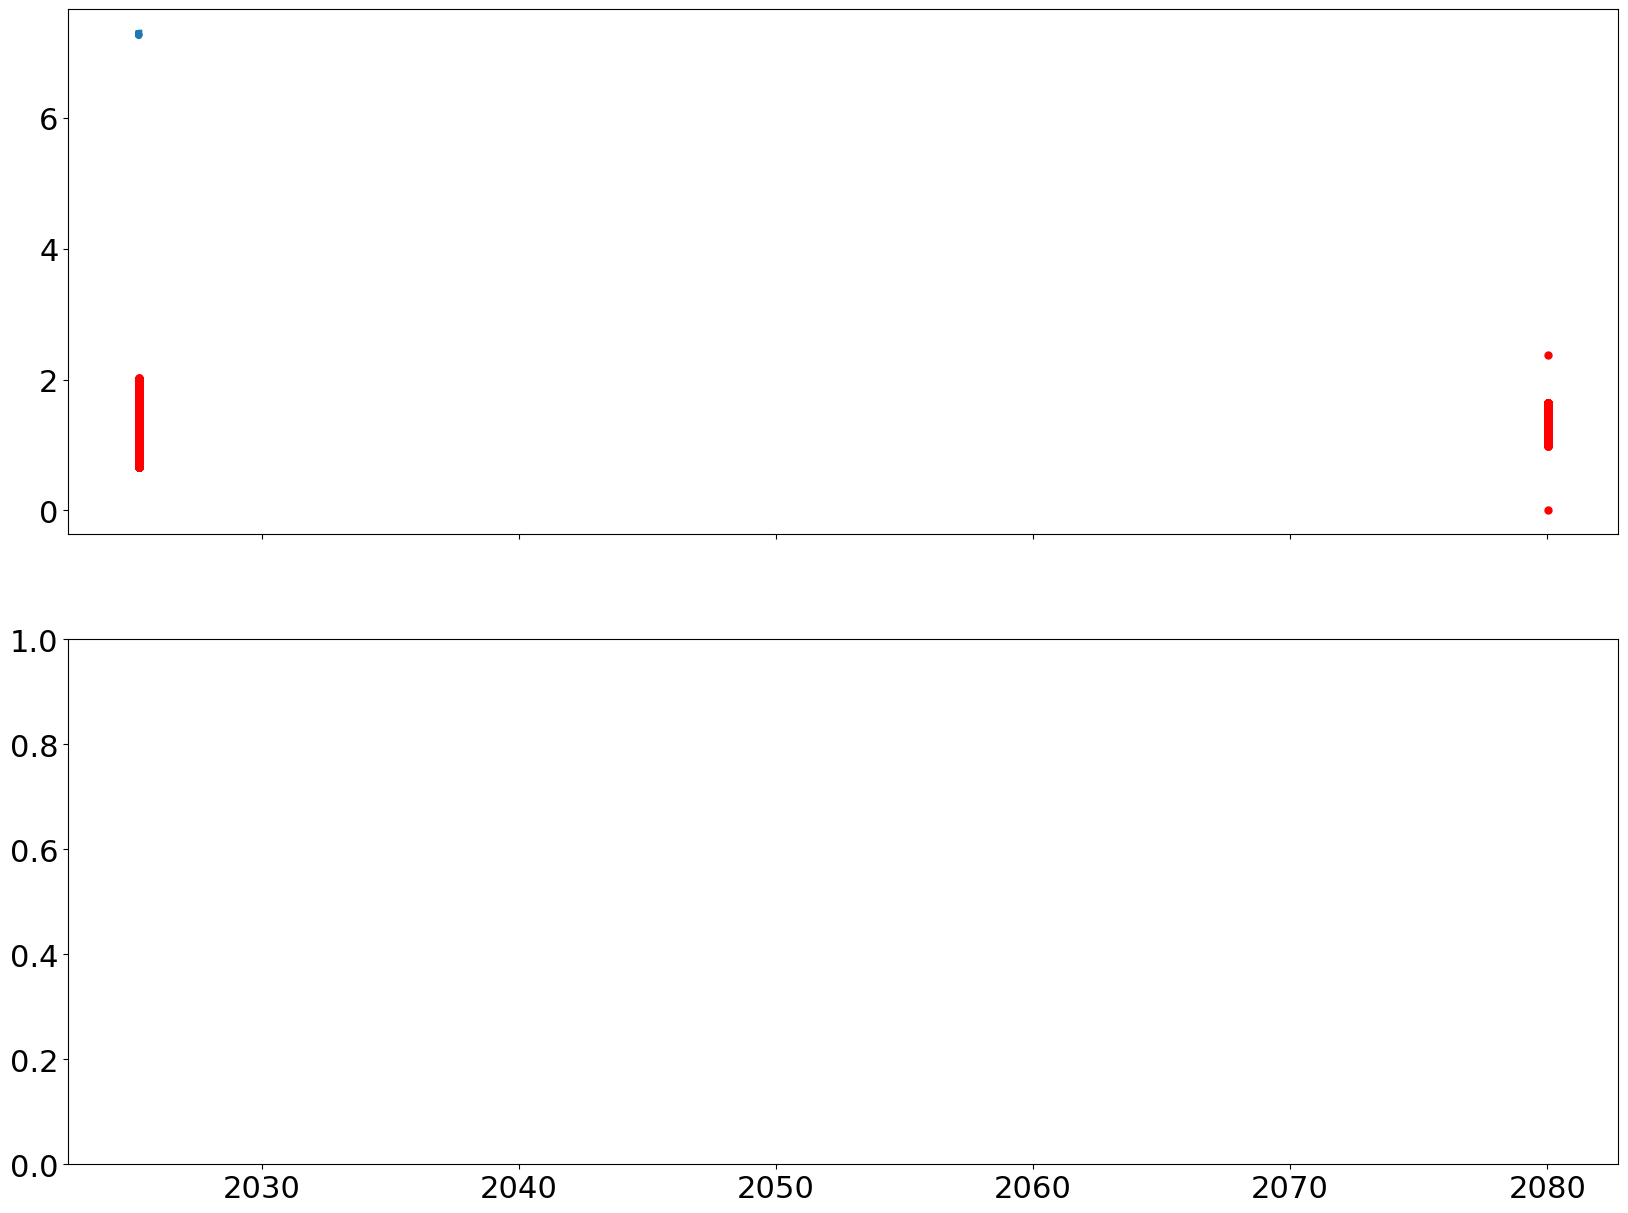

In [25]:
rmse_drifter = np.sqrt(np.sum((Drifter_minus_YSI_anomaly)**2)/(len(Drifter_minus_YSI_anomaly)))

print(np.nanmean(Drifter_minus_YSI_anomaly), np.nanstd(Drifter_minus_YSI_anomaly), rmse_drifter)

plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize=(20, 15), nrows = 2, sharex = True)

# Plot YSI EXO2s oxygen data
axs[0].plot(YSItime, YSIdf.loc[:, 'ODO mg/L'], '-', label="YSI EXO2s", linewidth=5)

# Plot Drifter DO data
axs[0].plot(df.loc[:, 'time'], df.loc[:, 'DO (mg/L)'], 'ro', label="Drifter", markersize = 5)

### Describe
After repeating this for your variables of interest, describe what you see and what could be going on. Dig deeper into the sensor manuals (especially the Atlas sensors) to (1) confirm you're comparing apples to apples (e.g., conductivity to conductivity, not conductivity to specific conductivity, for instance), (2) understand why there might be offsets/differing variability, (3) determine whether more can be done to get the values to come closer to agreeing. For (3), examples might include: additional calculations to ensure you're comparing apples to apples, calibration checks following Atlas's recommendations or other options that we can discuss, etc. 

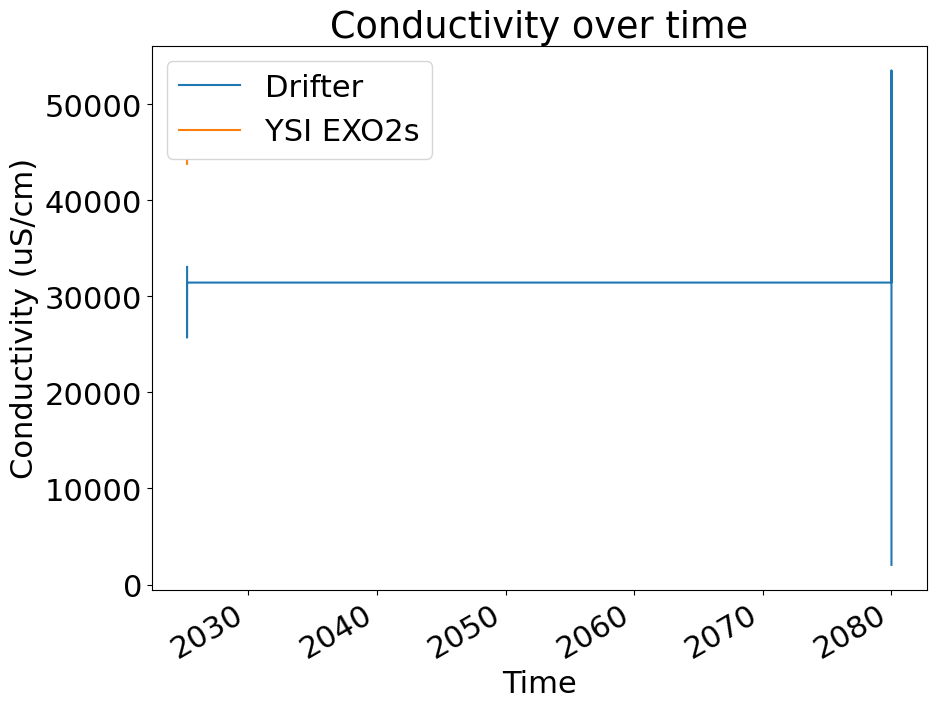

In [27]:

r = 0.0191 #taken from https://in-situ.com/uk/pub/media/support/documents/Specific-Conductance-as-an-Output-Unit-for-Conductivity-Readings-Tech-Note.pdf?srsltid=AfmBOorCrC34rz2-u7FivCA1360XG7FOcGRU4EQ4-8JsYUYBz3V8cfu0
acond = spcond*(1+r*(temp-25))
YSIcond = YSIdf['Cond µS/cm']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,acond, label = 'Drifter')
plt.plot(YSItime,YSIcond, label = 'YSI EXO2s')
plt.title('Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()



                

Text(0, 0.5, 'YSI')

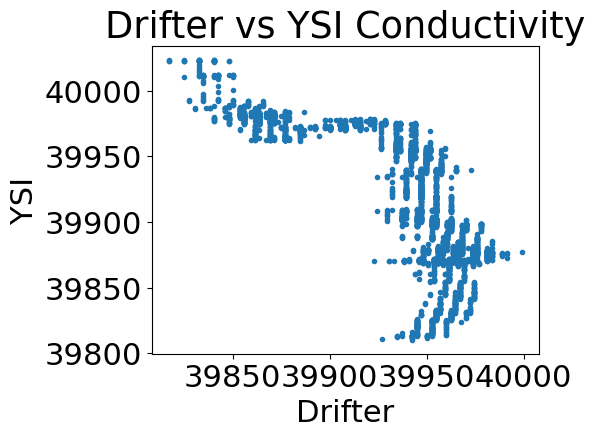

In [107]:
### YSI vs Drifter correlation
YSIcond_reduced = YSIcond[::2]

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (5,4)) # PJB: explicitly create graph objects for subsequent access
plt.plot(acond,YSIcond_reduced, '.')

plt.title('Drifter vs YSI Conductivity')
plt.xlabel('Drifter')
plt.ylabel('YSI')
